# Quick EDA book-crossing dataset

In [1]:
import pandas as pd

In [2]:
ratings = pd.read_csv("../data/raw/BX-Book-Ratings.csv", delimiter=";")
books = pd.read_csv("../data/raw/BX-Books.csv", delimiter=";", escapechar='\\')
users = pd.read_csv("../data/raw/BX-Users.csv", delimiter=";")

## First overview

### Data types and missing values

In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


No null values, ISBN stored as object. Likely due to the letter "X" in ISBN-10.

In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271377 non-null  object
 3   Year-Of-Publication  271379 non-null  int64 
 4   Publisher            271377 non-null  object
 5   Image-URL-S          271379 non-null  object
 6   Image-URL-M          271379 non-null  object
 7   Image-URL-L          271379 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.6+ MB


No null values, ISBN again stored as object.

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


No null values.

### Dataset choice

Main interest for this project are the following features:
- ISBN to identify book
- user ID to create profile of user preference
- book rating to express which book each user liked how much
- genre for interaction with the model later on (will be added in the script via API and ISBN)
- book title to remember book easier

Nice to have features as miscellaneous information:
- book author
- year of publication 
- publisher

Not required features:
- user location
- user age
- image URLs

Given the not required features, the **users** dataset can be fully excluded. Additionally, the image URLs can be removed from the **books** dataset.

In [6]:
books.drop(['Image-URL-S','Image-URL-M','Image-URL-L'], axis=1, inplace=True)

### Rename columns

In [7]:
ratings.columns = ['user_id', 'isbn', 'book_rating']
books.columns = ["isbn", "book_title", "book_author", "publication_year", "publisher"] 

## Analyzing numerical features

### Ratings distribution

In [8]:
ratings.describe()

,user_id,book_rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


Rating scale seems to go from 0 to 10 and the average is at around 4.

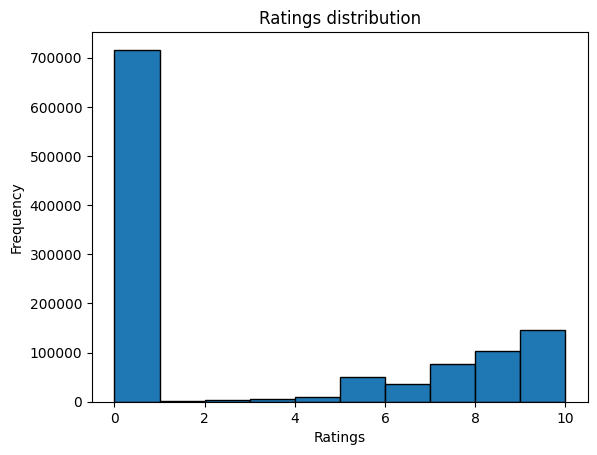

In [9]:
import matplotlib.pyplot as plt

plt.hist(ratings["book_rating"], color='tab:blue', edgecolor='black')

plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Ratings distribution')

plt.show()


Bulk of the ratings are set to 0, which scews the mean to around 4.

**Note:** 0 does not mean that a user utterly dislikes a book. Rather, it means that a user likes a book but didn't give any rating. So we're essentially missing information here. The dataframe will be split into two categories in the code scripts later. It's okay to leave it as is for this quick EDA.

In [10]:
# explicit_ratings = ratings[ratings["Book-Rating"] != 0]
# implicit_ratings = ratings[ratings["Book-Rating"] == 0]

### publication year distribution

In [11]:
books.describe()

,publication_year
count,271379.000000
mean,1959.756050
std,258.011363
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


Publication years span from 0 all the way to 2050. Both extremes need to be dealt accordingly, but as the publication year is not important for this project, further cleaning will not be applied here.

## Clean ISBN numbers

There are two official types of ISBNs:
- ISBN-10 consisting of 10 digits
- ISBN-13 consisting of 13 digits

In [12]:
ratings["isbn"].apply(len).value_counts()

isbn
10    1139363
9        5139
11       2150
13       1740
12        700
8         678
14         10
Name: count, dtype: int64

Many ISBN rows have neither 10 digits nor 13 digits. Each row should be checked for valid ISBN format by converting them to canonical form.

In [13]:
books["isbn"].apply(len).value_counts()

isbn
10    271375
13         3
11         1
Name: count, dtype: int64

Only 1 row with an unusual number of digits. Same as above, each row should be checked for valid ISBN format by converting them to canonical form.

In [14]:
import isbnlib
ratings["isbn"] = ratings["isbn"].apply(isbnlib.canonical)
books["isbn"] = books["isbn"].apply(isbnlib.canonical)

In [15]:
ratings["isbn"].apply(len).value_counts()

isbn
10    1139303
0        9293
13       1184
Name: count, dtype: int64

In [16]:
books["isbn"].apply(len).value_counts()

isbn
10    271262
0        117
Name: count, dtype: int64

Now we only have valid ISBN formats. Invalid ones were mapped to an empty string and can be removed.

In [17]:
ratings = ratings[ratings["isbn"] != ""]
books = books[books["isbn"] != ""]

## Check for duplicates

### Duplicate ratings

First, we check for rows containing users who have multiple ratings for a single specific book.

In [18]:
ratings.duplicated(subset=["user_id", "isbn"]).sum()

15

It's tricky to decide which rating of the user to keep for a single book. To prevent bias, all rows containing duplicates will be simply removed. This shouldn't affect the precision much as the number of duplicates is low compared to the total number of ratings.

In [19]:
ratings = ratings.drop_duplicates(subset=["user_id", "isbn"], keep=False)

## Duplicate books

This time we check for duplicate ISBN numbers, as it's the index of the dataframe.

In [20]:
books["isbn"].duplicated().sum()

315

After cleaning the ISBN numbers, we're left with 315 duplicate books now. This time we do keep one of the duplicates each.

In [21]:
books = books.drop_duplicates(subset=["isbn"])

## Final wrap-up

Here are now our final dataframes.

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1140457 entries, 0 to 1149778
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1140457 non-null  int64 
 1   isbn         1140457 non-null  object
 2   book_rating  1140457 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 34.8+ MB


After cleaning the dataset we are down now from 1149780 to 1140472 rows.

In [23]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270947 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   isbn              270947 non-null  object
 1   book_title        270947 non-null  object
 2   book_author       270945 non-null  object
 3   publication_year  270947 non-null  int64 
 4   publisher         270945 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


For the books dataset we are down from 271379 to 270947 rows.

**Note:** 2 authors and 2 publishers missing. But they are not of importance for the purposes of this project so this issue will be ignored.